In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn import preprocessing

In [2]:
file = ['data/raw/allTB-sarcoid-scdata.csv', 'data/raw/NHP-TB-scdata.csv']

In [3]:
# load data as dataframes
sarcoid_df = pd.read_csv(file[0])
NHP_TB_df = pd.read_csv(file[1])

In [4]:
# remove unnecessary cell label and patient ROI information
sarcoid_df = sarcoid_df.drop(['cellLabelInImage', 'PatientROI'],  axis='columns')
sarcoid_df = sarcoid_df[sarcoid_df.C.notnull()]
sarcoid_df.to_csv('data/processed/sarcoid.csv')

NHP_TB_df = NHP_TB_df.drop(['cellLabelInImage', 'PatientID'],  axis='columns')
NHP_TB_df.to_csv('data/processed/NHP_TB.csv')

In [5]:
# make column labels consistent
sarcoid_df = sarcoid_df.rename(columns={"Vimentin": "VIM", "PD.L1": "PDL1", "HLA.DR.DQ.DP": "HLA.DR", "Keratin.pan": "Keratin"})

# add label to sarcoid and TB data
sarcoid_df['Disease'] = [0] * len(sarcoid_df)
NHP_TB_df['Disease'] = [1] * len(NHP_TB_df)

In [6]:
# combine sarcoidosis and TB data together
all_df = pd.concat([sarcoid_df, NHP_TB_df])
all_df = all_df.dropna(axis=1)
all_df.reset_index(drop=True, inplace=True)

In [7]:
# standardize cell size 
stand_scaler = preprocessing.MinMaxScaler()
x_scaled = stand_scaler.fit_transform(all_df['cellSize'].values.reshape(-1,1))
all_df['cellSize'] = pd.DataFrame(x_scaled,columns=['cellSize'])

all_df.to_csv('data/processed/TB_sarc_overlap_nodum.csv')

In [8]:
# one-hot encoding for categorical variables 
all_df_cat = pd.get_dummies(all_df, columns=['Tissue','lineage','cell_type','cell_lin'])

all_df_cat.to_csv('data/processed/TB_sarc_overlap.csv')

In [9]:
all_df_cat = all_df_cat.drop(['SampleID','Disease'], axis='columns')

# create target list of lineage; convert nuclear = 0, cytoplasm = 1, both = 2
lin_dict = {'endothelial': 0, 'epithelial': 1, 'fibroblast': 2, 'immune': 3}

# lin_col will be the labels for lineage
lin_col = []
for i in range(len(all_df)):
    lin_col.append(lin_dict[all_df.lineage[i]])

## PCA

Variance explained by first two PCA vectors for TB/sarc data: 0.26520907064352783


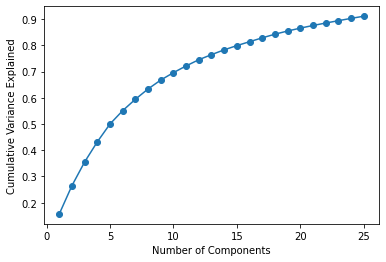

In [10]:
# perform PCA and plot variance over components
n=25
pca = PCA(n_components=n)
data_pca = pca.fit_transform(all_df_cat)
ratio = pca.explained_variance_ratio_

print("Variance explained by first two PCA vectors for TB/sarc data:", ratio[0]+ratio[1])

x = range(1,n+1)
y = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure()
plt.plot(x,y, marker='o');
plt.xlabel('Number of Components');
plt.ylabel('Cumulative Variance Explained');
fig.savefig('figures/gran_cumvar_PCA.png')

In [11]:
# perform PCA with 2 components
pca = PCA(n_components=2)
data_pca = pca.fit_transform(all_df_cat)

data_pca_df = pd.DataFrame(data = data_pca, columns = ['PC 1', 'PC 2'])

print(pca.explained_variance_ratio_)

[0.15706165 0.10814742]


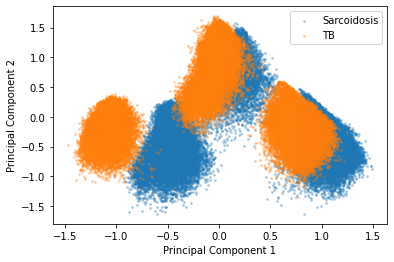

In [12]:
# plot PCA targeting disease
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
targets = [0, 1]
leg = ['Sarcoidosis', 'TB']

# plot each tumor type label in different color
for target in targets:
    ind = all_df['Disease'] == target
    ax.scatter(data_pca_df.loc[ind, 'PC 1']
               , data_pca_df.loc[ind, 'PC 2']
               , alpha=0.3, s=3);
    
ax.legend(leg, loc='best');
fig.savefig('figures/gran_dis_PCA.png')

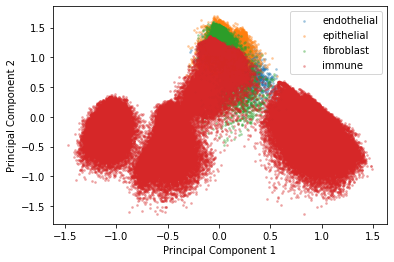

In [13]:
# plot PCA targeting cell lineage
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
targets = np.unique(all_df['lineage'])

# plot each tumor type label in different color
for target in targets:
    ind = all_df['lineage'] == target
    ax.scatter(data_pca_df.loc[ind, 'PC 1']
               , data_pca_df.loc[ind, 'PC 2']
               , alpha=0.3, s=3);
    
ax.legend(targets, loc='best');
# ax.set_xlim([-1.6, 1.6])
# ax.set_ylim([-1.6, 1.6])
fig.savefig('figures/gran_lin_PCA.png')

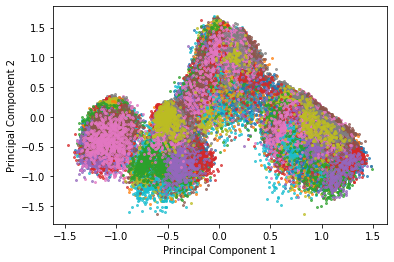

In [14]:
# plot PCA targeting patient ID
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
targets = np.unique(all_df['SampleID'])

# plot each tumor type label in different color
for target in targets:
    ind = all_df['SampleID'] == target
    ax.scatter(data_pca_df.loc[ind, 'PC 1']
               , data_pca_df.loc[ind, 'PC 2']
               , alpha=0.7, s=4);
    
# ax.legend(targets, loc='best');
fig.savefig('figures/gran_sampleID_PCA2.png')

### feature importance

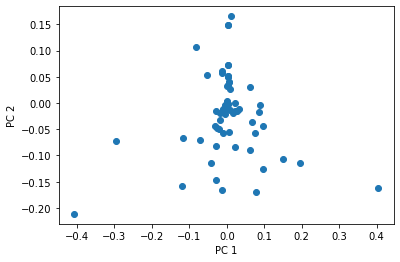

In [15]:
# determine PCA loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load1 = loadings[:,0]
load2 = loadings[:,1]

# plot loadings for PC1 and PC2
fig = plt.figure()
plt.scatter(load1, load2);
plt.xlabel('PC 1');
plt.ylabel('PC 2');
fig.savefig('figures/gran_load12.png')

In [16]:
# determine top two features contributing

# find combined contribution to PC1 and PC2 for each feature
comb_weight = []
for i in range(len(all_df_cat.columns)):
    comb_weight.append(np.sqrt(load1[i]**2 + load2[i]**2))
    
# find order of indices after sorting from low to high values of combined weight of features
sort_index = np.argsort(comb_weight)
feat1 = all_df_cat.columns[sort_index[-1]]
feat2 = all_df_cat.columns[sort_index[-2]]
feat3 = all_df_cat.columns[sort_index[-3]]
print('Top three features from combined PC1/2 loadings: ' + feat1 + ', ' + feat2 + ', ' + feat3)

sort_index = np.argsort(np.abs(load1))
feat1 = all_df_cat.columns[sort_index[-1]]
feat2 = all_df_cat.columns[sort_index[-2]]
feat3 = all_df_cat.columns[sort_index[-3]]
print('Top three features from PC1 loadings: ' + feat1 + ', ' + feat2 + ', ' + feat3)

sort_index = np.argsort(np.abs(load2))
feat1 = all_df_cat.columns[sort_index[-1]]
feat2 = all_df_cat.columns[sort_index[-2]]
feat3 = all_df_cat.columns[sort_index[-3]]
print('Top three features from PC2 loadings: ' + feat1 + ', ' + feat2 + ', ' + feat3)

Top three features from combined PC1/2 loadings: cell_lin_myeloid, cell_lin_lymphocyte, cell_type_Mac_Mono
Top three features from PC1 loadings: cell_lin_myeloid, cell_lin_lymphocyte, cell_type_Mac_Mono
Top three features from PC2 loadings: cell_lin_myeloid, CD45, cell_lin_nonimmune
